In [348]:
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [349]:
def load_emails(path, email_type):
    rows = []
    for email in os.listdir(path):
        content = Path(path, email).read_text(encoding='latin-1')
        contents = {'Type': email_type, 'Content': content}
        rows.append(contents)
        
    return pd.DataFrame(rows, columns=['Type', 'Content'])
    
hard_ham = load_emails('hard_ham/', 'ham')
easy_ham = load_emails('easy_ham/', 'ham')
spam = load_emails('spam/', 'spam')

print('hard ham: ', len(hard_ham))
print('easy ham: ', len(easy_ham))
print('spam: ', len(spam))

hard ham:  250
easy ham:  2551
spam:  501


In [350]:
# fit learns the vocabulary
# transform creates a document-term matrix using the vocabulary
def bayes(X_train, X_test, Y_trainlabel, Y_testlabel, filter_words=None):
    vectorizer = CountVectorizer(stop_words=filter_words, encoding='latin-1')
    X_train_count = vectorizer.fit_transform(X_train)
    X_test_count = vectorizer.transform(X_test)

    # 1. Multinomial Naive Bayes - discrete data. Total Count
    multinomial_model = MultinomialNB()
    multinomial_model.fit(X_train_count, Y_trainlabel)
    multinomial_pred = multinomial_model.predict(X_test_count)

    # 2. Bernoulli Naive Bayes - binary
    vectorizer = CountVectorizer(stop_words=filter_words, encoding='latin-1', binary=True)
    X_train_count = vectorizer.fit_transform(X_train)
    X_test_count = vectorizer.transform(X_test)
    
    bernoulli_model = BernoulliNB()
    bernoulli_model.fit(X_train_count, Y_trainlabel)
    bernoulli_pred = bernoulli_model.predict(X_test_count)

    multinomial_cm = metrics.confusion_matrix(Y_testlabel, multinomial_pred)
    bernoulli_cm = metrics.confusion_matrix(Y_testlabel, bernoulli_pred)
    
    mTN = multinomial_cm[0][0]
    mFN = multinomial_cm[1][0]
    mTP = multinomial_cm[1][1]
    mFP = multinomial_cm[0][1]
    
    bTN = bernoulli_cm[0][0]
    bFN = bernoulli_cm[1][0]
    bTP = bernoulli_cm[1][1]
    bFP = bernoulli_cm[0][1]
    
    # Make subplots
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(12, 4)
    labels=['Spam', 'Not Spam']
    
    sns.heatmap(multinomial_cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues", ax=ax[0])
    ax[0].set_ylabel('Predicted')
    ax[0].set_xlabel('Actual')
    ax[0].set_title('Multinomial')
    
    sns.heatmap(bernoulli_cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues", ax=ax[1])
    ax[1].set_ylabel('Predicted')
    ax[1].set_xlabel('Actual')
    ax[1].set_title('Bernoulli')
    
    # Scores TPR = TP/TP+FN, TNR = TN/FP+TN
    print('Multinomial %: ', accuracy_score(Y_testlabel, multinomial_pred))
    print('True Spam: ', "{:.2f}".format(mTP /(mFP+mTP)))
    print('True Ham: ', "{:.2f}".format(mTN /(mTN+mFN)))
    
    print('Bernoulli %: ', accuracy_score(Y_testlabel, bernoulli_pred)) 
    print('True Spam: ', "{:.2f}".format(bTP /(bFP+bTP)))
    print('True Ham: ', "{:.2f}".format(bTN /(bTN+bFN)))

Multinomial %:  0.945
True Spam:  1.00
True Ham:  0.90
Bernoulli %:  0.915
True Spam:  1.00
True Ham:  0.85


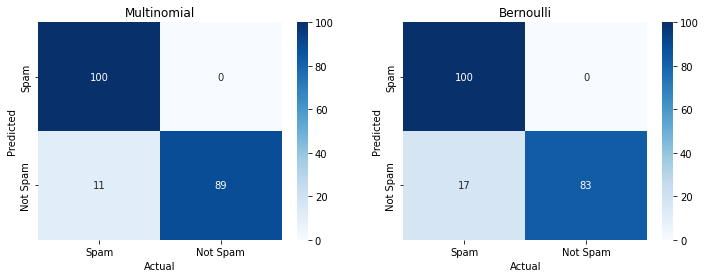

In [351]:
# Spam vs easy-ham
# hard ham:  250
# easy ham:  2551
# spam:  501
easy_ham_sampled = easy_ham.sample(501)

spam_train = spam.sample(frac = 0.8,random_state=25)
spam_test = spam.drop(spam_train.index,axis = 0)

ham_train = easy_ham_sampled.sample(frac = 0.8,random_state=25)
ham_test = easy_ham_sampled.drop(ham_train.index,axis = 0)

X_train = pd.concat([ham_train,spam_train])
X_test = pd.concat([ham_test,spam_test])
Y_trainlabel = X_train.Type
Y_testlabel = X_test.Type
X_train = X_train.Content
X_test = X_test.Content

bayes(X_train, X_test, Y_trainlabel, Y_testlabel)

Multinomial %:  0.85
True Spam:  0.81
True Ham:  0.91
Bernoulli %:  0.81
True Spam:  0.77
True Ham:  0.86


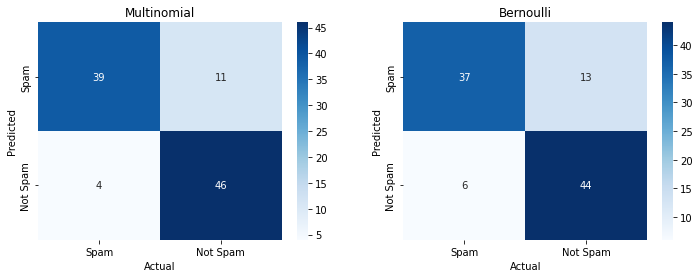

In [352]:
# Spam vs hard-ham
# hard ham:  250
# easy ham:  2551
# spam:  501
spam_sampled = spam.sample(250)

spam_train = spam_sampled.sample(frac = 0.8,random_state=25)
spam_test = spam_sampled.drop(spam_train.index,axis = 0)

ham_train = hard_ham.sample(frac = 0.8,random_state=25)
ham_test = hard_ham.drop(ham_train.index,axis = 0)

X_train = pd.concat([ham_train,spam_train])
X_test = pd.concat([ham_test,spam_test])
Y_trainlabel = X_train.Type
Y_testlabel = X_test.Type
X_train = X_train.Content
X_test = X_test.Content

bayes(X_train, X_test, Y_trainlabel, Y_testlabel)

In [353]:
# 5. Filter out the headers and the footers of the emails before you run on them. The format may
# vary somewhat between emails, which can make this a bit tricky, so perfect filtering is not
# required. Run your program again and answer the following questions:
import email
import re

def extract_body(e):
    body = ""
    b = email.message_from_string(e)
    if b.is_multipart():
        for part in b.walk():
            ctype = part.get_content_type()
            if ctype == 'text/plain':
                return str(part.get_payload(decode=True))
            if ctype == 'text/html':
                body = part.get_payload(decode=True)
                return str(re.sub('<[^<]+?>', '', body.decode('latin-1')))
    else:
        body = b.get_payload(decode=True)
        return str(re.sub('<[^<]+?>', '', body.decode('latin-1')))

In [369]:
import warnings
warnings.filterwarnings("ignore")
# To avoid classification based on common and uninformative words it is common to filter
# these out.
# a. Argue why this may be useful. Try finding the words that are too common/uncommon
# in the dataset.
#emails = pd.concat([spam, hard_ham, easy_ham])
#emails['Body'] = [extract_body(element) for element in emails['Content']]
pd.set_option("display.max_rows", None, "display.max_columns", None)

spam['Body'] = [extract_body(element) for element in spam['Content']]
hard_ham['Body'] = [extract_body(element) for element in hard_ham['Content']]
easy_ham['Body'] = [extract_body(element) for element in easy_ham['Content']]

def filter_common(email_group):
    words = Counter(" ".join(email_group.Body).split())
    most_common = words.most_common(100)
    return most_common

def filter_uncommon(email_group):
    words = Counter(" ".join(email_group.Body).split())
    least_common = [word for word in words if words[word] == 1]
    return least_common
    
filtered_common_spam = filter_common(spam)
filtered_uncommon_spam = filter_uncommon(spam)

filtered_common_hard_ham = filter_common(hard_ham)
filtered_uncommon_hard_ham = filter_uncommon(hard_ham)

filtered_common_easy_ham = filter_common(easy_ham)
filtered_uncommon_easy_ham = filter_uncommon(easy_ham)

least_common = filtered_uncommon_spam + filtered_uncommon_hard_ham + filtered_uncommon_easy_ham

#print('Common Words in Spam: ', filtered_common_spam, '\n')
#print('Common words in Hard Ham: ', filtered_common_hard_ham, '\n')
#print('Common words in Easy Ham: ', filtered_common_easy_ham, '\n')

df1 = pd.DataFrame(filtered_common_spam)
df2 = pd.DataFrame(filtered_common_hard_ham)
df3 = pd.DataFrame(filtered_common_easy_ham)

x1 = df1.iloc[:,0]
x2 = df2.iloc[:,0]
x3 = df3.iloc[:,0]

in_common = list(set(x1) & set(x2) & set(x3))

filtered_words = in_common + least_common

Multinomial %:  0.97
True Spam:  0.97
True Ham:  0.97
Bernoulli %:  0.88
True Spam:  0.99
True Ham:  0.81


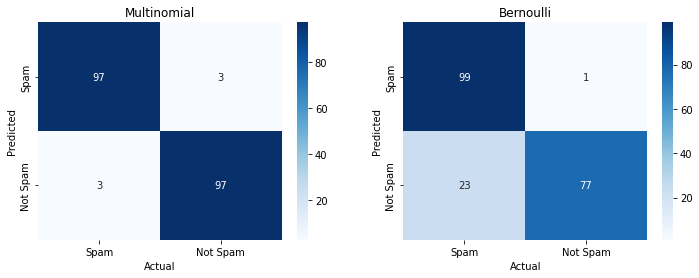

In [370]:
# a. Does the result improve from 3 and 4?

# Spam vs easy-ham with filtering and removing common/uncommon words
# hard ham:  250
# easy ham:  2551
# spam:  501
from sklearn.model_selection import train_test_split
easy_ham['Body'] = [extract_body(element) for element in easy_ham['Content']]
spam['Body'] = [extract_body(element) for element in spam['Content']]

easy_ham_sampled = easy_ham.sample(501)

spam_train = spam.sample(frac = 0.8,random_state=25)
spam_test = spam.drop(spam_train.index,axis = 0)

ham_train = easy_ham_sampled.sample(frac = 0.8,random_state=25)
ham_test = easy_ham_sampled.drop(ham_train.index,axis = 0)

X_train = pd.concat([ham_train,spam_train])
X_test = pd.concat([ham_test,spam_test])
Y_trainlabel = X_train.Type
Y_testlabel = X_test.Type
X_train = X_train.Body
X_test = X_test.Body

bayes(X_train, X_test, Y_trainlabel, Y_testlabel, filtered_words)

Multinomial %:  0.9
True Spam:  0.93
True Ham:  0.87
Bernoulli %:  0.82
True Spam:  0.76
True Ham:  0.92


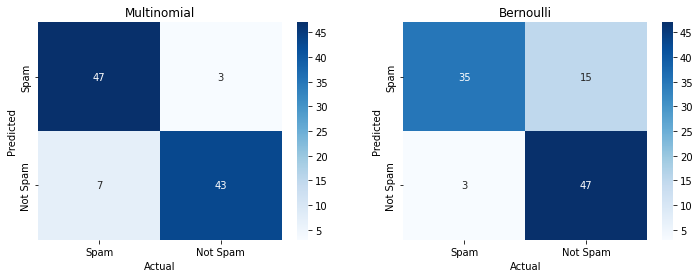

In [371]:
# Spam vs hard-ham with filtering and removing common/uncommon words
# hard ham:  250
# easy ham:  2551
# spam:  501
hard_ham['Body'] = [extract_body(element) for element in hard_ham['Content']]
spam['Body'] = [extract_body(element) for element in spam['Content']]

spam_sampled = spam.sample(250)

spam_train = spam_sampled.sample(frac = 0.8,random_state=25)
spam_test = spam_sampled.drop(spam_train.index,axis = 0)

ham_train = hard_ham.sample(frac = 0.8,random_state=25)
ham_test = hard_ham.drop(ham_train.index,axis = 0)

X_train = pd.concat([ham_train,spam_train])
X_test = pd.concat([ham_test,spam_test])
Y_trainlabel = X_train.Type
Y_testlabel = X_test.Type
X_train = X_train.Body
X_test = X_test.Body

bayes(X_train, X_test, Y_trainlabel, Y_testlabel, filtered_words)

In [375]:
def filter_common(email_group):
    words = Counter(" ".join(email_group.Content).split())
    most_common = words.most_common(100)
    return most_common

def filter_uncommon(email_group):
    words = Counter(" ".join(email_group.Content).split())
    least_common = [word for word in words if words[word] == 1]
    return least_common
    
filtered_common_spam = filter_common(spam)
filtered_uncommon_spam = filter_uncommon(spam)

filtered_common_hard_ham = filter_common(hard_ham)
filtered_uncommon_hard_ham = filter_uncommon(hard_ham)

filtered_common_easy_ham = filter_common(easy_ham)
filtered_uncommon_easy_ham = filter_uncommon(easy_ham)

least_common = filtered_uncommon_spam + filtered_uncommon_hard_ham + filtered_uncommon_easy_ham

df1 = pd.DataFrame(filtered_common_spam)
df2 = pd.DataFrame(filtered_common_hard_ham)
df3 = pd.DataFrame(filtered_common_easy_ham)

x1 = df1.iloc[:,0]
x2 = df2.iloc[:,0]
x3 = df3.iloc[:,0]

in_common = list(set(x1) & set(x2) & set(x3))

filtered_words = in_common + least_common

Multinomial %:  0.965
True Spam:  1.00
True Ham:  0.93
Bernoulli %:  0.93
True Spam:  1.00
True Ham:  0.88


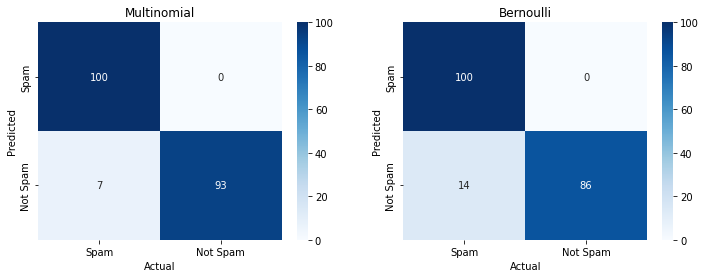

In [376]:
# Spam vs easy-ham with removing common/uncommon words
# hard ham:  250
# easy ham:  2551
# spam:  501
easy_ham_sampled = easy_ham.sample(501)

spam_train = spam.sample(frac = 0.8,random_state=25)
spam_test = spam.drop(spam_train.index,axis = 0)

ham_train = easy_ham_sampled.sample(frac = 0.8,random_state=25)
ham_test = easy_ham_sampled.drop(ham_train.index,axis = 0)

X_train = pd.concat([ham_train,spam_train])
X_test = pd.concat([ham_test,spam_test])
Y_trainlabel = X_train.Type
Y_testlabel = X_test.Type
X_train = X_train.Content
X_test = X_test.Content

bayes(X_train, X_test, Y_trainlabel, Y_testlabel, filtered_words)

Multinomial %:  0.88
True Spam:  0.82
True Ham:  0.97
Bernoulli %:  0.85
True Spam:  0.77
True Ham:  1.00


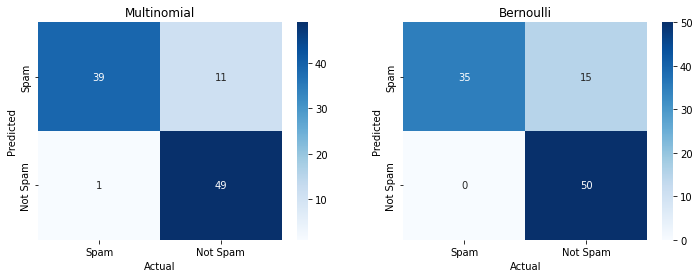

In [377]:
# Spam vs hard-ham with removing common/uncommon words
# hard ham:  250
# easy ham:  2551
# spam:  501
spam_sampled = spam.sample(250)

spam_train = spam_sampled.sample(frac = 0.8,random_state=25)
spam_test = spam_sampled.drop(spam_train.index,axis = 0)

ham_train = hard_ham.sample(frac = 0.8,random_state=25)
ham_test = hard_ham.drop(ham_train.index,axis = 0)

X_train = pd.concat([ham_train,spam_train])
X_test = pd.concat([ham_test,spam_test])
Y_trainlabel = X_train.Type
Y_testlabel = X_test.Type
X_train = X_train.Content
X_test = X_test.Content

bayes(X_train, X_test, Y_trainlabel, Y_testlabel, filtered_words)